In [1]:
# First set up the environment. Code sources are in folders which are in the parent folder of this notebooks scope.
import sys; sys.path.insert(0, '..') # add parent folder path, now files are queriable from parent folder

Load the data from files

In [2]:
from data.query.util import loadJson

notHitSongPath = '../data/datasets/spotify/not_hit_song.json'
hitSongPath = '../data/datasets/spotify/hit_song.json'


hits = loadJson(hitSongPath)
notHits = loadJson(notHitSongPath)

Sneak peak on the structure of the data

In [4]:
print(hits[0].keys())
print(hits[0]['info'].keys())
print(hits[0]['features'].keys())

dict_keys(['info', 'features'])
dict_keys(['spotifyData', 'searchQuery', 'minMatchingRatioUsed', 'originalData'])
dict_keys(['timeSignature', 'durationMS', 'key', 'mode', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo'])


Now all hits will be added a label 1 and not hits are labeled as 0. 0s and 1s are used because the model needs a numerical input as the correct label when training. For example in MLP model (https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) the weights of the model are adjusted so that the output will be closer to the label value the model has been given.

This is called **binary classification**, essentially the numerical output for a song ( spotify feature values as input) from the model is used to classify the song of being a hit > 0.5 or not < 0.5.

In the scope of this modeling a song can only be a hit or a not hit.

In [5]:
for hitsTotal, hit in enumerate(hits):
    hit['labels'] = {'hit': 1}

for notHitsTotal, notHit in enumerate(notHits):
    notHit['labels'] = {'hit': 0}

To show some plots about the data **matplotlib**s pyplot need to be imported.

In [6]:
from matplotlib import pyplot as plt

def makeHistogram(labels, data):
    plt.bar(labels, data)
    plt.xticks(range(1, len(labels)))
    plt.show()

19463
83775


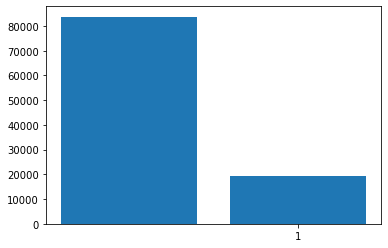

In [7]:
print(hitsTotal)
print(notHitsTotal)

makeHistogram([0, 1], [notHitsTotal, hitsTotal])

As this majestic histogram shows, there are a lot of not hits compared to hits.

To efficiently train the model, data needs to be balanced. Here is a good article about the subject https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5

There are a few tricks to apply the balancing with, but here I chose the **under sampling** of not hit songs. The amount of hits (almost 20k) is sufficient amount of data in my papers, so if the not hit dataset is under sampled to match this amount the result is a balanced dataset with 40k songs.

If the undersampling is done totally randomly, there's a possibility to have another imbalanced datset on the not hit side. The sampling can end up choosing most of the songs before 70s for example. This would just manifest the original problem in a different form. So to ensure this doesn't happen, the samples need to take same amount in every time period. Year is a good enough measure for it and that information is available in the song meta data under albums release date. This doesn't necessarily tell when exactly the song has been released, but it's a good enough measure.

In [ ]:
from data.types.spotify import SpotifySongData
from data.types.process import SongFeaturesAndLabels, ModelFeatures

def parseYearFromDate(date: str) -> int:
    if '-' in date:
        split = date.split('-')
        if len(split) == 3:
            year, month, day = split
        elif len(split) == 2:
            year, month = split
        return year
            
    elif len(date) == 4:
        return date
    
    return ""

def parseToFeaturesAndLabels(songs: list[SpotifySongData]) -> list[SongFeaturesAndLabels]:
    featuresAndLabels: list[SongFeaturesAndLabels] = []
    for songData in songs:
        features = songData['features']
        releaseDate = parseYearFromDate(songData['info']['spotifyData']['album']['releaseDate'])

        if releaseDate == 0 or len(features.values()) != 13:
            # If there's no date ignore the song
            continue
            
        modelFeatures: ModelFeatures = {
            **features, 
            'releaseYear': releaseDate
        }
        label = songData['labels']['hit']
        
        songFeaturesAndLabels: SongFeaturesAndLabels = {
            'spotifyID': songData['info']['spotifyData']['songID'],
            'features': modelFeatures,
            'label': label
        }
        featuresAndLabels.append(songFeaturesAndLabels)
        
    return featuresAndLabels


With hit songs it is straight forward. The songs doesn't need any sampling

In [ ]:
from collections import Counter

parsedHitSongs = parseToFeaturesAndLabels(hits)
parsedNotHitSongs = parseToFeaturesAndLabels(notHits)

print("HITS")
# Plot histogram where amount of hits are by release date
#print(sorted(Counter([song['features']['releaseYear'] for song in parsedHitSongs]).items(), key=lambda x: x[1]))
labels, amounts = zip(*sorted(Counter([song['features']['releaseYear'] for song in parsedHitSongs]).items(), key=lambda x: x[1]))
makeHistogram(labels, amounts)
print("NOT HITS")
# Not hit hist
nlabels, namounts = zip(*sorted(Counter([song['features']['releaseYear'] for song in parsedNotHitSongs]).items(), key=lambda x: x[1]))
makeHistogram(nlabels, namounts)

The data is quite unbalanced between release years.

And split with decade:

In [ ]:
from collections import Counter

decades = []
for song in parsedHitSongs:
    year = song['features']['releaseYear']    
    if year > '1939':
        # Dropping songs released before 1939
        decades.append(year[2]+"0")

print("HITS")
#print(sorted(Counter(decades).items(), key=lambda x: x[1]))
labels, amounts = zip(*sorted(Counter(decades).items(), key=lambda x: x[1]))
#print(amounts[:10], labels[:10])
makeHistogram(labels, amounts)

ndecades = []
for song in parsedNotHitSongs:
    year = song['features']['releaseYear']    
    if year > '1939':
        # Dropping songs released before 1939
        ndecades.append(year[2]+"0")
        
print("NOT HITS")
nlabels, namounts = zip(*sorted(Counter(ndecades).items(), key=lambda x: x[1]))
#print(amounts[:10], labels[:10])
makeHistogram(nlabels, namounts)

In [ ]:
print(Counter(decades))

Alright so the hit songs aren't evenly distrubuted among years. This means that some additional filtering can be helpful.

In this situation it looks like the best way to sample the songs is: 
 1. Ignore all songs released in the 50s.
 2. Take from every decade the same amount of songs that is released in the 20s
 
There are 1107 songs in the data that's released in the 20s so if we take this amount of songs from every decade, the final model will be trained with a dataset of 7 decades * 1107 = 7749 hit songs, so dataset of 15 498 songs in total.

This is quite a small dataset in size, but it's enough to see if there's something to find.

Here's the decade sampling implementation:

In [ ]:
#Checkpoint
import sys; sys.path.insert(0, '..') # add parent folder path, now files are queriable from parent folder

from data.query.util import loadJson

notHitSongPath = '../data/datasets/spotify/not_hit_song.json'
hitSongPath = '../data/datasets/spotify/hit_song.json'


hits = loadJson(hitSongPath)
notHits = loadJson(notHitSongPath)

for hitsTotal, hit in enumerate(hits):
    hit['labels'] = {'hit': 1}

for notHitsTotal, notHit in enumerate(notHits):
    notHit['labels'] = {'hit': 0}
    
from data.types.spotify import SpotifySongData
from data.types.process import SongFeaturesAndLabels, ModelFeatures

def parseYearFromDate(date: str) -> int:
    if '-' in date:
        split = date.split('-')
        if len(split) == 3:
            year, month, day = split
        elif len(split) == 2:
            year, month = split
        return year
            
    elif len(date) == 4:
        return date
    
    return ""

def parseToFeaturesAndLabels(songs: list[SpotifySongData]) -> list[SongFeaturesAndLabels]:
    featuresAndLabels: list[SongFeaturesAndLabels] = []
    for songData in songs:
        features = songData['features']
        releaseDate = parseYearFromDate(songData['info']['spotifyData']['album']['releaseDate'])
        if releaseDate == 0 or len(features.values()) != 13:
            # If there's no date ignore the song
            continue
            
        modelFeatures: ModelFeatures = {
            **features, 
            'releaseYear': releaseDate
        }
        label = songData['labels']['hit']
        
        songFeaturesAndLabels: SongFeaturesAndLabels = {
            'spotifyID': songData['info']['spotifyData']['songID'],
            'features': modelFeatures,
            'label': label
        }
        featuresAndLabels.append(songFeaturesAndLabels)
        
    return featuresAndLabels

parsedHitSongs = parseToFeaturesAndLabels(hits)
parsedNotHitSongs = parseToFeaturesAndLabels(notHits)

In [ ]:
# To figure out if there's a need to keep track of duplicates

# Collect all hit and not hit song spotify ids (unique)
hitSpotiIds = [song['spotifyID'] for song in parsedHitSongs]
# Using Counter and filter take all spotify hit ids that are duplicates
duplicateHits = dict(filter(lambda x: x[1] > 1, Counter(hitSpotiIds).items()))

# Same operations to not hits
notHitSpotiIds = [song['spotifyID'] for song in parsedNotHitSongs]
duplicateNotHits = dict(filter(lambda x: x[1] > 1, Counter(notHitSpotiIds).items()))

print("Hit amount %d from which uniqes %d duplicates %d" % (len(hitSpotiIds), len(set(list(hitSpotiIds))), len(hitSpotiIds)-len(set(list(hitSpotiIds)))))
print("Not hit amount %d from which uniqes %d duplicates %d" % (len(notHitSpotiIds), len(set(list(notHitSpotiIds))), len(notHitSpotiIds)-len(set(list(notHitSpotiIds)))))
print("\nTotal amount %d from which uniqes %d duplicates %d" % (len(notHitSpotiIds+hitSpotiIds), len(set(list(notHitSpotiIds+hitSpotiIds))), len(notHitSpotiIds+hitSpotiIds)-len(set(list(notHitSpotiIds+hitSpotiIds)))))

In [ ]:
print(duplicateHits, "\n")
print(duplicateNotHits)

Hmm... there are multiple duplicates. These songs need to be cleared.
Basically there's a few cases:

1. Hit song is twice or more times in hit song list
2. Not hit song is twice or more times in not hit song list
3. Hit song is accidentially in not hit song list

Not hit songs were collected by randomly selecting songs from an album that the hit song was pointing in spotify data. Therefore if another hit song was on that same album it can be wrongly added also as not hit as there was no checking in this step.

All these duplicates can be just removed by making a dictionary with spotify id as the key. Then if there's duplicate it will not be added two times.

In [ ]:
# Split the songs into decades

hitSpotiIds = [song['spotifyID'] for song in parsedHitSongs]

# By assigning the songs in dictionaries where key is spotify id, the duplicates will be dropped
# with no hits the id needs to be checked not belonging to hit ids
hitSongsInDecades = {
    '10': {},
    '20': {},
    '60': {},
    '70': {},
    '80': {},
    '90': {},
    '00': {},
}
for song in parsedHitSongs:
    year = song['features']['releaseYear']    
    if year >= '1960':
        # Dropping songs released before 60s
        hitSongsInDecades[year[2]+"0"][song['spotifyID']] = (song['features'], song['label'])

notHitSongsInDecades = {
    '10': {},
    '20': {},
    '60': {},
    '70': {},
    '80': {},
    '90': {},
    '00': {},
}
for song in parsedNotHitSongs:
    year = song['features']['releaseYear']    
    if year >= '1960':
        # Dropping songs released before 60s
        
        # Check that the song is not actually a hit song
        if song['spotifyID'] not in hitSpotiIds:
            notHitSongsInDecades[year[2]+"0"][song['spotifyID']] = (song['features'], song['label'])

In [ ]:
print(hitSongsInDecades['10'])

Now that the songs are bucketed based on the release year and duplicates have been removed (within hit/noHits and between noHits and hits), sampling can be applied.

To balance the dataset more, the decades are sampled evenly using the smallest amount for songs in a decade (~1000). So from every hit and not hit decade a ~1000 songs are taken randomly to act as the full dataset.

In [ ]:
from random import sample as rndsample
from numpy import ndarray
from typing import Literal

from data.types.process import ModelFeatures

sampleInstance = tuple[ModelFeatures, int]

def getSampleSize(sampleData):
    # The sample size is taken from decade with smallest song amount
    return min(len(values) for key, values in sampleData.items())

def handleFeatures(sampleSongs: list[sampleInstance]):
    formatted = []
    for featuresAndLabel in sampleSongs:
        features, label = featuresAndLabel
        formatted.append(([float(f) for f in list(features.values())], label))
    return formatted

def takeSamplesFromDecades(songsInDecades: dict, sampleSize: int) -> list[sampleInstance]:
    # For every decade
    samples = []
    for decade, songs in songsInDecades.items():
        samples = samples + handleFeatures(rndsample(list(songs.values()), sampleSize))
    return samples
        
hitSongSamples = takeSamplesFromDecades(hitSongsInDecades, getSampleSize(hitSongsInDecades))
# Note: the sample size is from min hit song size so the hit and not hit song datasets are balanced
notHitSongSamples = takeSamplesFromDecades(notHitSongsInDecades, getSampleSize(hitSongsInDecades))
print(len(hitSongSamples), len(notHitSongSamples))

# The dataset can now be combined
songSamples = hitSongSamples + notHitSongSamples
print(len(songSamples))
print(songSamples[0])

Above is one instance of the sampled data. The numeric and string (year) values were converted to floats but this is not enough. Machine learning models usually perform best when the data is in the same scale. For example now the duration field would have an huge impact on the model as the value is much bigger than the rest.

To apply scaling scikit learn has a class to perform this.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import array as nparray, append as npappend, set_printoptions as npset_printoptions

npset_printoptions(suppress=True)

for i, sample in enumerate(songSamples):
    if i == 0:
        x = [nparray(sample[0], dtype='float32')]
        y = [nparray(nparray(sample[1], dtype='float32'))]
        continue
        
    x = npappend(x, [nparray(sample[0], dtype='float32')], axis=0)
    y = npappend(y, [nparray(nparray(sample[1], dtype='float32'))], axis=0)


print(x.shape)
# Make a multidimensional array

scaler = MinMaxScaler()
scaler.fit(x)
print("MAX")
print(scaler.data_max_)
print("MIN")
print(scaler.data_min_)
print("\n")

# Let's see how the scaling affect the features
print(x[:5])
print(scaler.transform(x[:5]))

Above max and min values are printed among the dataset. Also a sample of 5 is transformed to illustrate the transformation.

Some more insights can be displayed with scipy describe function:

In [ ]:
from scipy.stats import describe

desc_x = describe(x)

for i in range(len(x[0])):
    f = i+1
    print("Feature %d "% f)
    print("Min: ", desc_x.minmax[0][i])
    print("Max: ", desc_x.minmax[1][i])
    print("Mean: ", desc_x.mean[i])
    print("Variance: ", desc_x.variance[i])
    print("Skewness: ", desc_x.skewness[i])
    print("Kurtosis: ", desc_x.kurtosis[i])

Now the data can be transformed with the scaler and split into train, validation and test datasets.

Scikit learns train_test_split will be used.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

x, y = shuffle(x, y)
transformed_x = scaler.transform(x)
# Dataset to train and test
x_train, x_test, y_train, y_test = train_test_split(transformed_x, y, test_size=0.33, stratify=y)
# Split train to validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, stratify=y_train)

print("Training set")
print(x_train.shape, y_train.shape)
print("Test set")
print(x_test.shape, y_test.shape)
print("Validation set")
print(x_val.shape, y_val.shape)

In [ ]:
from pathlib import Path
from numpy import save as npsave
startPath = '../data/datasets/readyDatasets/'

if not Path(startPath).exists():
    Path(startPath).mkdir()

# Save the datasets
with open(startPath + 'trainX.npy', 'wb') as f:
    npsave(f, x_train)
with open(startPath + 'trainY.npy', 'wb') as f:
    npsave(f, y_train)
    
with open(startPath + 'valX.npy', 'wb') as f:
    npsave(f, x_val)
with open(startPath + 'valY.npy', 'wb') as f:
    npsave(f, y_val)

with open(startPath + 'testX.npy', 'wb') as f:
    npsave(f, x_test)
with open(startPath + 'testY.npy', 'wb') as f:
    npsave(f, y_test)

In [ ]:
from numpy import load as npload

startPath = '../data/datasets/readyDatasets/'

# And load datasets
with open(startPath + 'trainX.npy', 'rb') as f:
    x_train = npload(f)
with open(startPath + 'trainY.npy', 'rb') as f:
    y_train = npload(f)
    
with open(startPath + 'valX.npy', 'rb') as f:
    x_val = npload(f)
with open(startPath + 'valY.npy', 'rb') as f:
    y_val = npload(f)

with open(startPath + 'testX.npy', 'rb') as f:
    x_test = npload(f)
with open(startPath + 'testY.npy', 'rb') as f:
    y_test = npload(f)

Everything is now set to feed to the model.

Scikit learns ready MLP model will be used.

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50), max_iter=200).fit(x_train, y_train)

print("Training set score: %f" % mlp.score(x_train, y_train))
print("Validation set score: %f" % mlp.score(x_val, y_val))
print("Test set score: %f" % mlp.score(x_test, y_test))